<a href="https://colab.research.google.com/github/myllanes/Introduction-to-Deep-Learning/blob/main/HW2_ALEXNET_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/100], Training Loss: 1.7413
Validation Loss: 1.3869, Validation Accuracy: 50.03%
Epoch [2/100], Training Loss: 1.3542
Validation Loss: 1.1639, Validation Accuracy: 58.31%
Epoch [3/100], Training Loss: 1.2093
Validation Loss: 1.0742, Validation Accuracy: 62.16%
Epoch [4/100], Training Loss: 1.1128
Validation Loss: 0.9567, Validation Accuracy: 66.30%
Epoch [5/100], Training Loss: 1.0428
Validation Loss: 0.8902, Validation Accuracy: 69.09%
Epoch [6/100], Training Loss: 0.9817
Validation Loss: 0.8828, Validation Accuracy: 69.21%
Epoch [7/100], Training Loss: 0.9378
Validation Loss: 0.8261, Validation Accuracy: 71.19%
Epoch [8/100], Training Loss: 0.9108
Validation Loss: 0.8180, Validation Accuracy: 71.51%
Epoch [9/100], Training Loss: 0.8889
Validation Loss: 0.7859, Validation Accuracy: 72.55%
Epoch [10/100], Training Loss: 0.8714
Validation Loss: 0.7693, Validation Accuracy: 73.52%
Epoch [11/100], Trainin

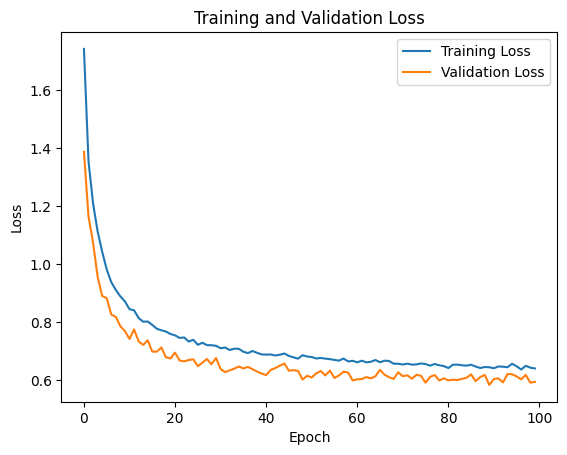

Total number of parameters: 5820298


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the modified AlexNet
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),  # Conv1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(p=0.25), #DropOUT

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),  # Conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(p=0.25), #DropOUT

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Conv3
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # Conv4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(p=0.25), #DropOUT
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),  # FC1
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.5), #DropOUT

            nn.Linear(1024, 512),  # FC2
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.5), #DropOUT

            nn.Linear(512, num_classes),  # FC3 (output layer)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training and validation loss and accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_loss_list.append(epoch_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_val_loss = val_loss / len(test_loader)
    val_loss_list.append(epoch_val_loss)

    val_accuracy = 100. * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]:.2f}%')

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
